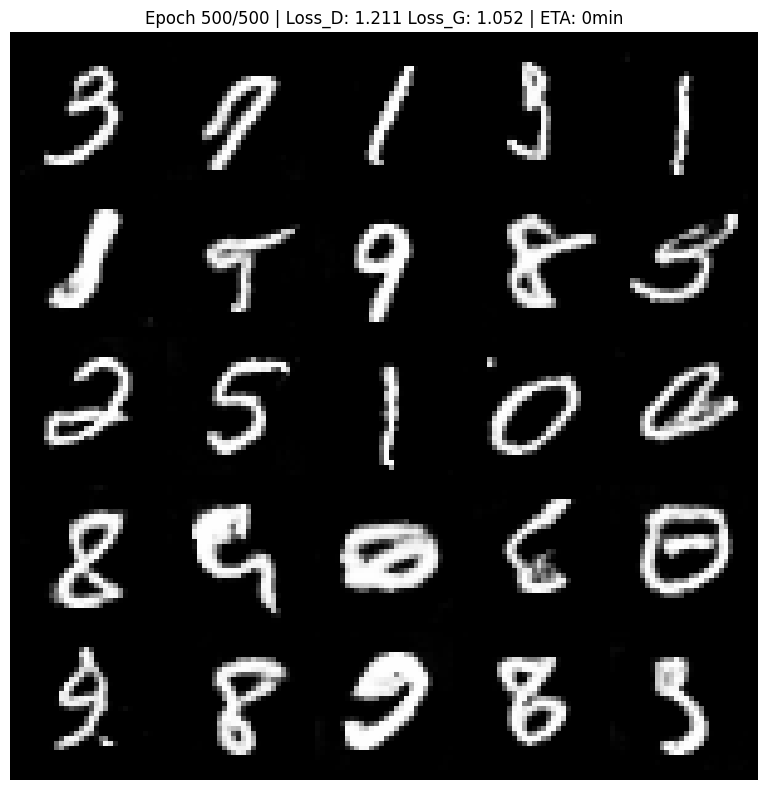


✅ TRAINING SELESAI!
⏱️ Total waktu: 1.67 jam (100 menit)
⚡ Rata-rata per epoch: 12.0s



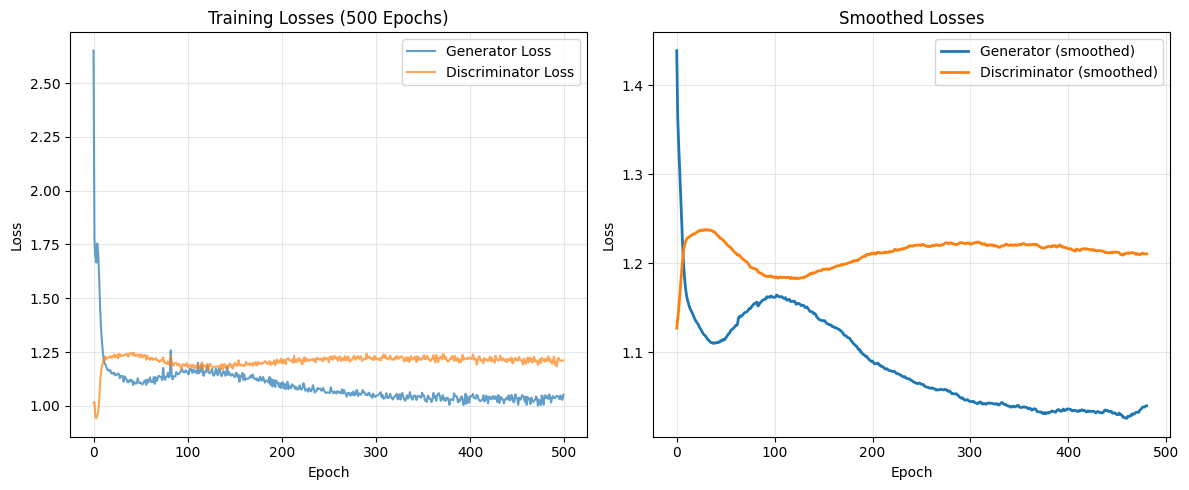

✅ Models saved!

🎨 GENERATE 5 GAMBAR BARU



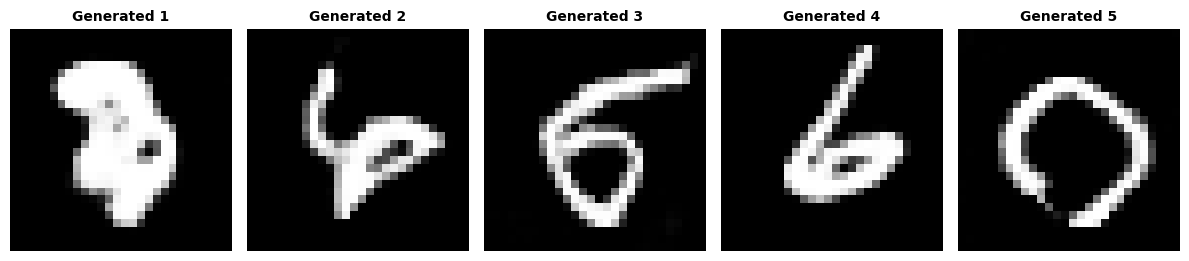


🔄 LATENT SPACE INTERPOLATION



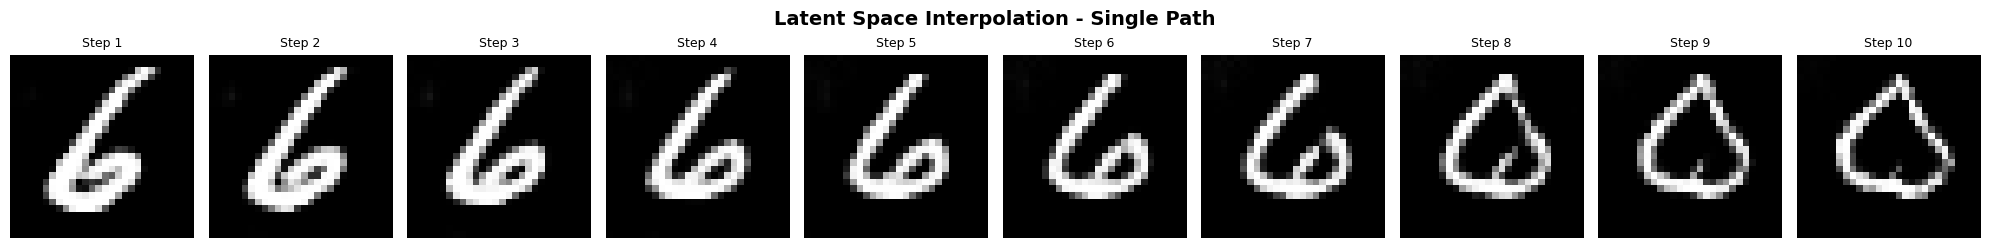

Membuat 5 jalur interpolasi berbeda...



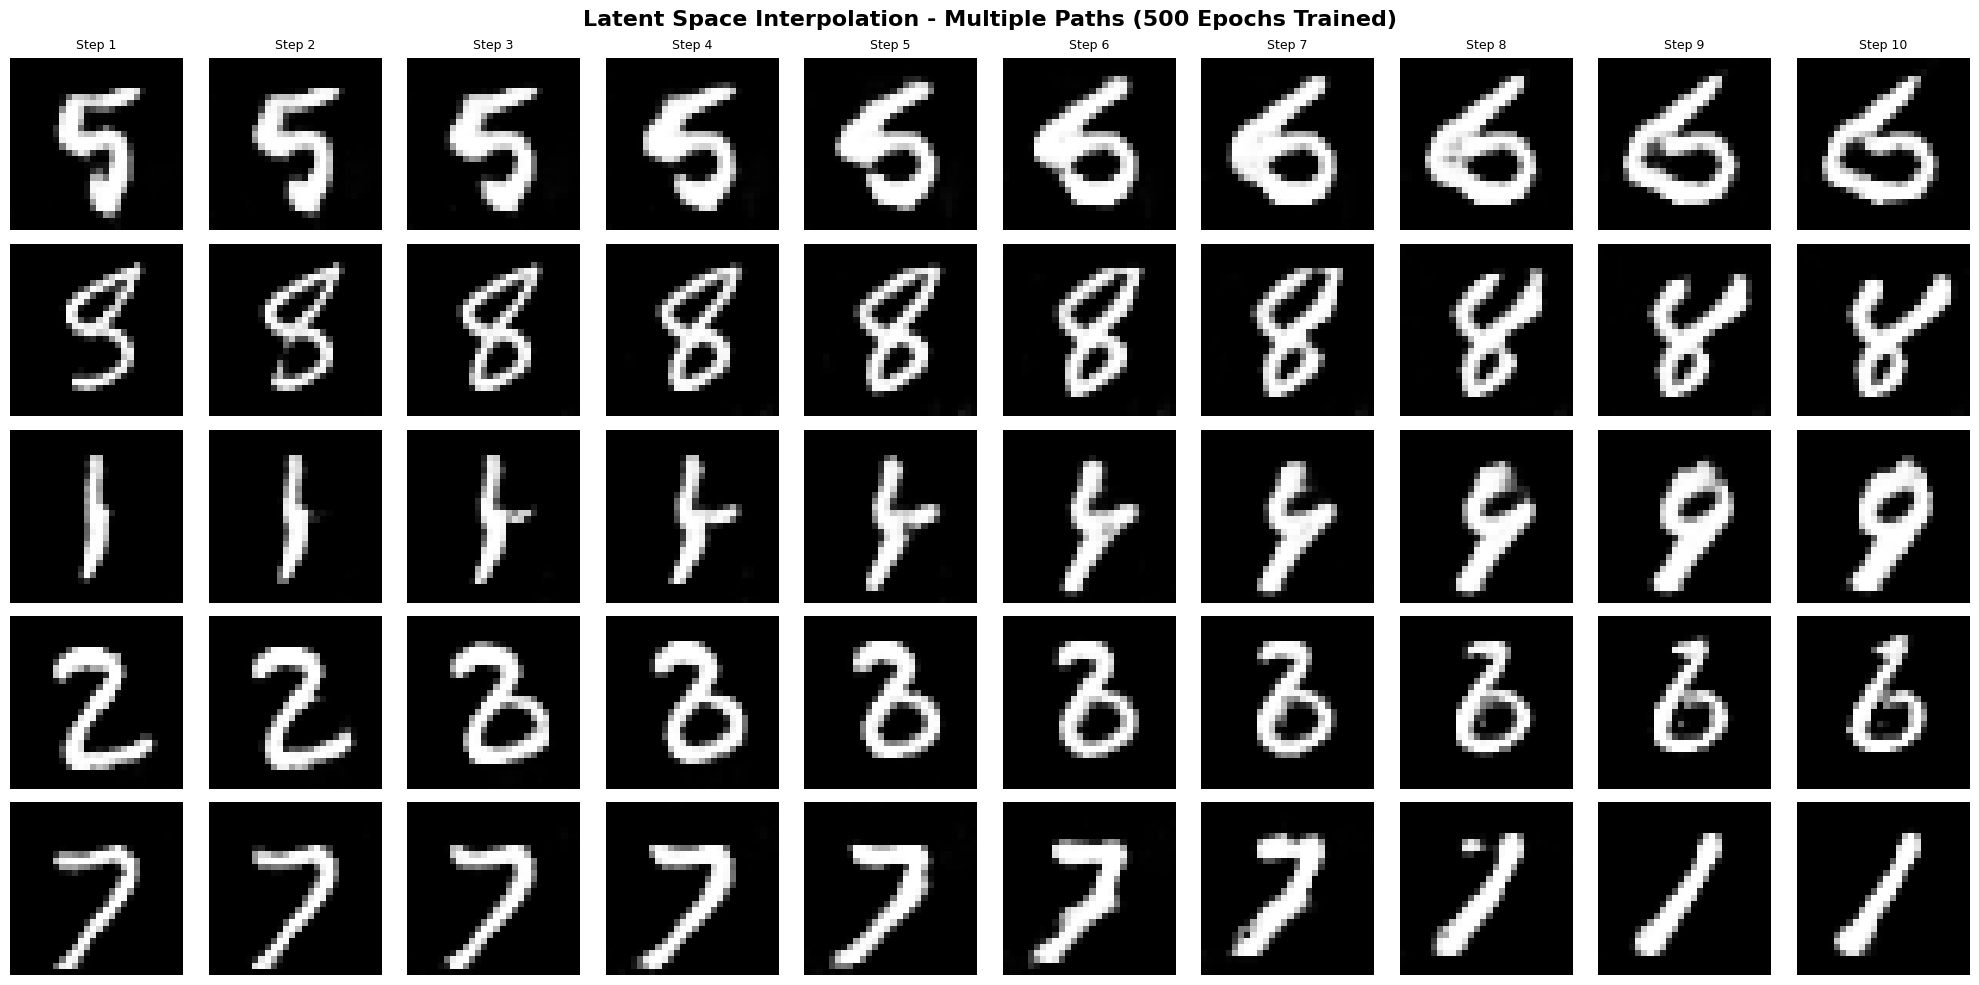

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display, Javascript
import os
import time

display(Javascript('''
function KeepClicking(){
   console.log("Keep-alive ping");
   document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(KeepClicking, 60000)
'''))

LATENT_DIM = 64
IMAGE_SIZE = 28
CHANNELS = 1
BATCH_SIZE = 512
LEARNING_RATE = 0.0002
BETA1 = 0.5
EPOCHS = 500
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

USE_AMP = True
scaler = torch.amp.GradScaler('cuda') if USE_AMP and torch.cuda.is_available() else None

os.makedirs("dcgan_outputs", exist_ok=True)
os.makedirs("dcgan_outputs/generated", exist_ok=True)
os.makedirs("dcgan_outputs/interpolations", exist_ok=True)

print("="*70)
print("🚀 DCGAN TRAINING - 500 EPOCHS")
print("="*70)
print(f"⚡ Device: {DEVICE}")
print(f"⚡ Mixed Precision: {USE_AMP and torch.cuda.is_available()}")
print(f"⚙️ Image Size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"⚙️ Batch Size: {BATCH_SIZE}")
print(f"⚙️ Latent Dim: {LATENT_DIM}")
print(f"⚙️ Epochs: {EPOCHS}")
print(f"⏱️ Estimated Time: ~2-3 hours with GPU (T4)")
print("="*70 + "\n")

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.main = nn.Sequential(

            nn.ConvTranspose2d(LATENT_DIM, 256, 7, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),


            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),


            nn.ConvTranspose2d(128, 1, 4, 2, 1, bias=False),
            nn.Tanh()

        )

    def forward(self, z):
        return self.main(z)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(

            nn.Conv2d(1, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.3),


            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.3),


            nn.Conv2d(256, 1, 7, 1, 0, bias=False)


        )

    def forward(self, x):
        return self.main(x).view(-1, 1)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

print(f"✅ Dataset loaded: {len(dataset):,} images")
print(f"✅ Batches per epoch: {len(dataloader)}\n")

generator = Generator().to(DEVICE)
discriminator = Discriminator().to(DEVICE)

generator.apply(weights_init)
discriminator.apply(weights_init)

try:
    generator = torch.compile(generator)
    discriminator = torch.compile(discriminator)
    print("✅ Models compiled with torch.compile()")
except:
    print("⚠️ torch.compile() not available (requires PyTorch 2.0+)")

print(f"✅ Generator parameters: {sum(p.numel() for p in generator.parameters()):,}")
print(f"✅ Discriminator parameters: {sum(p.numel() for p in discriminator.parameters()):,}\n")


criterion = nn.BCEWithLogitsLoss()
optimizer_G = optim.AdamW(generator.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999), weight_decay=0.0001)
optimizer_D = optim.AdamW(discriminator.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999), weight_decay=0.0001)

scheduler_G = optim.lr_scheduler.CosineAnnealingLR(optimizer_G, T_max=EPOCHS)
scheduler_D = optim.lr_scheduler.CosineAnnealingLR(optimizer_D, T_max=EPOCHS)

fixed_noise = torch.randn(25, LATENT_DIM, 1, 1, device=DEVICE)

print("="*70)
print("🚀 MULAI TRAINING - 500 EPOCHS")
print("="*70 + "\n")

G_losses = []
D_losses = []
epoch_times = []

total_start_time = time.time()

for epoch in range(EPOCHS):
    epoch_start = time.time()

    batch_g_loss = []
    batch_d_loss = []

    for i, (real_images, _) in enumerate(dataloader):
        batch_size = real_images.size(0)
        real_images = real_images.to(DEVICE, non_blocking=True)



        real_labels = torch.full((batch_size, 1), 0.9, device=DEVICE)
        fake_labels = torch.zeros(batch_size, 1, device=DEVICE)


        optimizer_D.zero_grad(set_to_none=True)

        if USE_AMP and scaler:
            with torch.amp.autocast('cuda'):
                output_real = discriminator(real_images)
                loss_D_real = criterion(output_real, real_labels)

                noise = torch.randn(batch_size, LATENT_DIM, 1, 1, device=DEVICE)
                fake_images = generator(noise)

                output_fake = discriminator(fake_images.detach())
                loss_D_fake = criterion(output_fake, fake_labels)

                loss_D = loss_D_real + loss_D_fake

            scaler.scale(loss_D).backward()
            scaler.step(optimizer_D)
        else:
            output_real = discriminator(real_images)
            loss_D_real = criterion(output_real, real_labels)

            noise = torch.randn(batch_size, LATENT_DIM, 1, 1, device=DEVICE)
            fake_images = generator(noise)
            output_fake = discriminator(fake_images.detach())
            loss_D_fake = criterion(output_fake, fake_labels)

            loss_D = loss_D_real + loss_D_fake
            loss_D.backward()
            optimizer_D.step()


        optimizer_G.zero_grad(set_to_none=True)

        if USE_AMP and scaler:
            with torch.amp.autocast('cuda'):
                output = discriminator(fake_images)
                loss_G = criterion(output, real_labels)

            scaler.scale(loss_G).backward()
            scaler.step(optimizer_G)
            scaler.update()
        else:
            output = discriminator(fake_images)
            loss_G = criterion(output, real_labels)
            loss_G.backward()
            optimizer_G.step()

        batch_g_loss.append(loss_G.item())
        batch_d_loss.append(loss_D.item())


    scheduler_G.step()
    scheduler_D.step()


    avg_g_loss = np.mean(batch_g_loss)
    avg_d_loss = np.mean(batch_d_loss)
    G_losses.append(avg_g_loss)
    D_losses.append(avg_d_loss)

    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)

    elapsed = time.time() - total_start_time
    avg_epoch_time = np.mean(epoch_times[-10:])
    eta = avg_epoch_time * (EPOCHS - epoch - 1)


    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1:3d}/{EPOCHS}] | "
              f"Loss_D: {avg_d_loss:.4f} | Loss_G: {avg_g_loss:.4f} | "
              f"Time: {epoch_time:.1f}s | ETA: {eta/60:.0f}min | "
              f"Elapsed: {elapsed/60:.0f}min")


    if (epoch + 1) % 50 == 0 or epoch == 0:
        with torch.no_grad():
            fake = generator(fixed_noise).detach().cpu()
            grid = make_grid(fake, nrow=5, normalize=True)
            save_image(grid, f'dcgan_outputs/generated/epoch_{epoch+1}.png')


            if (epoch + 1) % 100 == 0 or epoch == 0:
                clear_output(wait=True)
                fig = plt.figure(figsize=(8, 8))
                plt.imshow(np.transpose(grid, (1, 2, 0)))
                plt.title(f'Epoch {epoch+1}/{EPOCHS} | Loss_D: {avg_d_loss:.3f} Loss_G: {avg_g_loss:.3f} | ETA: {eta/60:.0f}min')
                plt.axis('off')
                plt.tight_layout()
                plt.show()

total_time = time.time() - total_start_time
print("\n" + "="*70)
print(f"✅ TRAINING SELESAI!")
print(f"⏱️ Total waktu: {total_time/3600:.2f} jam ({total_time/60:.0f} menit)")
print(f"⚡ Rata-rata per epoch: {np.mean(epoch_times):.1f}s")
print("="*70 + "\n")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(G_losses, label='Generator Loss', alpha=0.7, linewidth=1.5)
plt.plot(D_losses, label='Discriminator Loss', alpha=0.7, linewidth=1.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Losses (500 Epochs)')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)

window = 20
if len(G_losses) >= window:
    g_smooth = np.convolve(G_losses, np.ones(window)/window, mode='valid')
    d_smooth = np.convolve(D_losses, np.ones(window)/window, mode='valid')
    plt.plot(g_smooth, label='Generator (smoothed)', linewidth=2)
    plt.plot(d_smooth, label='Discriminator (smoothed)', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Smoothed Losses')
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('dcgan_outputs/losses.png', dpi=200)
plt.show()

torch.save({
    'epoch': EPOCHS,
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'optimizer_G_state_dict': optimizer_G.state_dict(),
    'optimizer_D_state_dict': optimizer_D.state_dict(),
    'g_losses': G_losses,
    'd_losses': D_losses,
}, 'dcgan_outputs/dcgan_checkpoint.pth')

torch.save(generator.state_dict(), 'dcgan_outputs/generator.pth')
print("✅ Models saved!\n")

print("="*70)
print("🎨 GENERATE 5 GAMBAR BARU")
print("="*70 + "\n")

generator.eval()
with torch.no_grad():
    noise = torch.randn(5, LATENT_DIM, 1, 1, device=DEVICE)
    generated_images = generator(noise).cpu()

    fig, axes = plt.subplots(1, 5, figsize=(12, 3))
    for idx, ax in enumerate(axes):
        img = generated_images[idx].squeeze()
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(f'Generated {idx+1}', fontsize=10, fontweight='bold')
    plt.tight_layout()
    plt.savefig('dcgan_outputs/generated/5_new_images.png', dpi=200)
    plt.show()

print("\n" + "="*70)
print("🔄 LATENT SPACE INTERPOLATION")
print("="*70 + "\n")

def interpolate_latent_space(generator, z1, z2, steps=10):
    alphas = np.linspace(0, 1, steps)
    interpolated_images = []

    with torch.no_grad():
        for alpha in alphas:
            z = (1 - alpha) * z1 + alpha * z2
            img = generator(z).cpu()
            interpolated_images.append(img)

    return torch.cat(interpolated_images, dim=0)

z1 = torch.randn(1, LATENT_DIM, 1, 1, device=DEVICE)
z2 = torch.randn(1, LATENT_DIM, 1, 1, device=DEVICE)
interpolated = interpolate_latent_space(generator, z1, z2, steps=10)

fig, axes = plt.subplots(1, 10, figsize=(20, 2.5))
for idx, ax in enumerate(axes):
    img = interpolated[idx].squeeze()
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Step {idx+1}', fontsize=9)
plt.suptitle('Latent Space Interpolation - Single Path', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('dcgan_outputs/interpolations/latent_interpolation.png', dpi=250)
plt.show()

print("Membuat 5 jalur interpolasi berbeda...\n")
fig, axes = plt.subplots(5, 10, figsize=(20, 10))
for row in range(5):
    z1 = torch.randn(1, LATENT_DIM, 1, 1, device=DEVICE)
    z2 = torch.randn(1, LATENT_DIM, 1, 1, device=DEVICE)
    interpolated = interpolate_latent_space(generator, z1, z2, steps=10)

    for col in range(10):
        img = interpolated[col].squeeze()
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].axis('off')

    axes[row, 0].set_ylabel(f'Path {row+1}', fontsize=11, fontweight='bold')

for col in range(10):
    axes[0, col].set_title(f'Step {col+1}', fontsize=9)

plt.suptitle('Latent Space Interpolation - Multiple Paths (500 Epochs Trained)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('dcgan_outputs/interpolations/multiple_interpolations.png', dpi=250)
plt.show()